<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/eurosae2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EUROSAE 2022
L'objectif de ce TP n'est pas de vous apprendre à coder mais de vous montrer ce qui est compliqué avec les expériences d'apprentissage : instabilité des comportements, durée des calculs...


## problème jouet
Pour commencer, nous allons juste aller manipuler un peu un *tout petit problème jouet* sur https://playground.tensorflow.org


## CIFAR 10
Passons maintenant sur **La** base de données de prototypage de la vision par ordinateur (dont on peut trouver une description ici https://www.cs.toronto.edu/~kriz/cifar.html ).

Pour cela nous utiliserons un code très inspiré de https://github.com/kuangliu/pytorch-cifar .

D'abord nous allons importé pytorch un des deux principaux moteurs de *deeplearning*

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms


maintenant nous allons chargé CIFAR10

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


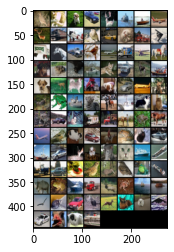

In [ ]:
transform_train = transforms.ToTensor()
transform_test = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

import matplotlib.pyplot as plt
batch = next(iter(trainloader))
batch = torchvision.utils.make_grid(batch[0])
plt.imshow(batch.permute(1, 2, 0))

 nous allons maintenant apprendre un classifier d'images VGG16

In [ ]:
net = torchvision.models.vgg16(pretrained=True)
net = net.cuda()
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

pour cela on distingue bien 2 phases : apprentissage et test (*normalement* on test que à la fin et on sélectionne **pas** le meilleur modèle - le faire revient à confondre validation et test).

In [ ]:
def train(epoch):
    print("\nEpoch: %d" % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 200 == 199:
            acc = 100.0 * correct / total
            print(train_loss / (batch_idx + 1), acc)
    return acc


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.0 * correct / total
    print("current accuracy", acc)

allons y pour quelques *epoches* (5mins normalement)

In [ ]:
for epoch in range(200):
    trainingacc = train(epoch)
    print("training accuracy", trainingacc)
    test(epoch)
    scheduler.step()
    if trainingacc > 97:
        break

Vous devriez arriver en 5mins à 86% d'accuracy.

Pourtant dans https://github.com/kuangliu/pytorch-cifar , on atteint jusqu'à 91% !

Qu'est ce qui fait cette différence ?
- de l'augmentation de données
- un learning rate plus fort qui limite le surapprentissage
- le fait de partir d'un réseau non préappris

In [ ]:
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root="./build/data", train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=100, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./build/data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./build/data/cifar-10-python.tar.gz to ./build/data
Files already downloaded and verified


In [ ]:
net = torchvision.models.vgg16(pretrained=True)
net = net.cuda()
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

relancer l'apprentissage pour 5mins pour observer la différence de comportement puis tuer l'execution

In [ ]:
for epoch in range(200):
    trainingacc = train(epoch)
    print("training accuracy", trainingacc)
    test(epoch)
    scheduler.step()
    if trainingacc > 97:
        break

Il se trouve que ce calcul prendrait une dizaine d'heures (si on va jusqu'au bout et qu'on enlève le préapprentissage)

-> on va gagner en performance (86% -> 91%) mais la convergence est **totalement différente** notamment en terme de durée (5mins -> 10h).

Changer un paramètre n'affecte donc pas seulement la fin d'apprentissage : les paramètres définissent le paysage énergétique et le comportement (voir https://proceedings.neurips.cc/paper/2019/hash/bce9abf229ffd7e570818476ee5d7dde-Abstract.html ). 

Pour ceux qui encadrent des travaux de deeplearning : 
- Cela ne doit pas tout *excuser* mais il est **réellement** difficile de régler un apprentissage !
- Il ne faut donc jamais commencer par essayer de reimplémenter quand un github préexiste !
- Et la qualité la plus importante pour un stagiaire est la rigueur (bien avant l'intelligence).
- Faites des cahiers d'expériences (j'en fais pas et je regrette à chaque fois).

## Le pire est à venir
On vient de voir qu'à la différence d'une méthode classique type SVM ou arbre de décision, le réglage d'un apprentissage de réseau de neurones profond est difficile.

Mais ce n'est encore rien comparer à des problèmes de renforcement 😱

**Petite introduction sur slide**

In [ ]:
import os
import numpy
import torch
import collections
import random


def distance(p, q):
    return abs(p[0] - q[0]) + abs(p[1] - q[1])


class stringmatrix:
    def __init__(self, rows, cols, val=None):
        self.internal = numpy.uint8(numpy.zeros((rows, cols + 1)))
        if val is not None:
            self.internal[:] = ord(val)
        self.internal[:, -1] = ord("\n")

    def set(self, row, col, char):
        self.internal[row][col] = ord(char)

    def get(self):
        tmp = self.internal.flatten()
        tmp = list(tmp)
        tmp = [chr(i) for i in tmp]
        return "".join(tmp)


class Buffer:
    def __init__(self, size):
        self.size = size
        self.data = collections.deque(maxlen=size)

    def randomize(self):
        tmp = list(self.data)
        random.shuffle(tmp)
        self.data = collections.deque(tmp, maxlen=self.size)

    def get(self, batchsize):
        tmp = []
        for i in range(batchsize):
            tmp.append(self.data.pop())
        return tmp

    def getvector(self, batchsize, shape):
        resultingsize = (batchsize, shape)
        state, stateafter = torch.zeros(resultingsize), torch.zeros(resultingsize)
        reward, action = torch.zeros(batchsize), torch.zeros(batchsize)

        tmp = self.get(batchsize)
        for i, (s, r, a, ss) in enumerate(tmp):
            state[i] = s
            reward[i] = r
            action[i] = a
            stateafter[i] = ss

        return state, stateafter, reward, action


In [ ]:


class DQN:
    def __init__(self, backbone):
        self.net = backbone

    def filtredforward(self, x):
        out = [self.net(x[i].unsqueeze(0))[0] for i in range(x.shape[0])]
        for i in range(x.shape[0]):
            if torch.isnan(out[i]).any():
                out[i] = torch.zeros(out[i].shape[0]).cuda()
                out[i].requires_grad = True
        return torch.stack(out, dim=0)

    def selectsingle(self, vectorstate):
        with torch.no_grad():
            tmp = self.net(vectorstate.unsqueeze(0))
            softmax = torch.nn.functional.softmax(tmp, dim=1)[0]
            softmax = softmax.cpu().numpy()
            obj_list = list(range(softmax.shape[0]))
            return int(numpy.random.choice(obj_list, p=softmax))

    def qabatch(self, vectorstate, action):
        tmp = self.filtredforward(vectorstate.cuda())
        out = [tmp[i][int(action[i])] for i in range(action.shape[0])]
        return torch.stack(out, dim=0)

    def qbatch(self, vectorstate):
        tmp = self.filtredforward(vectorstate.cuda())
        out = [torch.max(tmp[i]) for i in range(vectorstate.shape[0])]
        return torch.stack(out, dim=0)


def tuneDQN(dqn, replaybuffer, gamegenerator, parameters):
    nbtries, nbsteps, lr, alea, batchsize = parameters
    A = gamegenerator.getactionssize()
    S = gamegenerator.getvectorstatesize()

    print("exploration", nbtries, nbsteps, lr)
    dqn.net.cpu()
    valid = 0
    for i in range(nbtries):
        game = gamegenerator.getanother()
        for j in range(nbsteps):
            if game.isfinalstate():
                break

            s = game.getvectorstate()
            if random.randint(0, 100) <= alea:
                a = game.adhocmove()
            else:
                a = dqn.selectsingle(s)
            r = game.update(a)
            ss = game.getvectorstate()

            replaybuffer.data.append((s, r, a, ss))
            valid += 1

    print(valid)
    replaybuffer.randomize()
    dqn.net.cuda()
    optimizer = torch.optim.SGD(dqn.net.parameters(), lr=lr)
    valid = int(valid * 0.75 / batchsize)
    valid = max(valid, len(replaybuffer.data) // 10 // batchsize)
    print("tuning", valid * batchsize)

    for i in range(valid):
        lol = set()
        state, stateafter, reward, action = replaybuffer.getvector(batchsize, S)

        qas = dqn.qabatch(state, action)
        qss = dqn.qbatch(stateafter)

        tmp = qas - 0.9 * qss - reward.cuda() * 0.1
        loss = (tmp * tmp).mean()

        lossbis1 = 0.1 * tmp.abs().mean()
        lossbis2 = 0.1 * torch.nn.functional.relu(-tmp).mean()
        loss = loss + lossbis1 + lossbis2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 9:
            print(i, loss)
        if i == valid - 1:
            print(qas)
            print(qss)
            print(reward)

    print("eval")
    dqn.net.cpu()
    nbtries = nbtries // 10
    meansR = 0
    for i in range(nbtries):
        game = gamegenerator.getanother()
        R = 0
        for j in range(nbsteps):
            if game.isfinalstate():
                break

            s = game.getvectorstate()
            a = dqn.selectsingle(s)
            r = game.update(a)
            ss = game.getvectorstate()
            R += r

            replaybuffer.data.append((s, r, a, ss))
        meansR += R
    print("means R=", meansR / nbtries)


In [ ]:

class FrozenLake:
    def __init__(self):
        self.size = 4
        self.holes = [(2, 1), (3, 1), (0, 3)]
        self.start = (random.randint(0, 100) % self.size, 0)
        self.final = (random.randint(0, 100) % self.size, 2)

        self.isvalid = True
        self.steps = [self.start]
        self.current = self.start

    def getanother(self):
        return FrozenLake()

    def isfinalstate(self):
        return not self.isvalid

    def copy(self):
        out = FrozenLake()
        out.size = self.size
        out.holes = self.holes
        out.start = self.start
        out.final = self.final

        out.isvalid = self.isvalid
        out.step = self.steps.copy()
        out.current = self.current
        return out

    # static description of the game
    def getactionssize(self):
        return 4

    def getvectorstatesize(self):
        grids = ["holes", "position", "final"]
        return len(grids) * self.size * self.size

    # game instance
    def update_(self, action):
        if not self.isvalid:
            print("update an invalid state")
            quit()

        previousD = distance(self.final, self.current)

        if action == 0:
            self.current = (self.current[0] - 1, self.current[1])
        if action == 1:
            self.current = (self.current[0] + 1, self.current[1])
        if action == 2:
            self.current = (self.current[0], self.current[1] - 1)
        if action == 3:
            self.current = (self.current[0], self.current[1] + 1)

        if 0 <= self.current[0] < self.size and 0 <= self.current[1] < self.size:
            if self.current in self.holes:
                self.isvalid = False
                return -1000
            if self.current == self.final:
                self.isvalid = False
                return 1000 - len(self.steps) * 2
        else:
            self.isvalid = False
            return -1000

        self.steps.append(self.current)
        nextD = distance(self.final, self.current)
        if nextD < previousD:
            return 1
        else:
            return 0

    def update(self, action):
        #return self.update_(action) # -> holes kill

        tmp = self.copy()
        r = tmp.update_(action)
        if r < -500:
            return -2  # -> hole == wall
        else:
            return self.update_(action)

    def getvectorstate(self):
        if not self.isvalid:
            return torch.ones(self.getvectorstatesize()) * float("nan")

        gridshape = (self.size, self.size)
        gridsize = self.size * self.size
        holes = torch.ones(gridshape)
        for r, c in self.holes:
            holes[r][c] = 0

        position = torch.zeros(gridshape)
        position[self.current[0]][self.current[1]] = 1

        final = torch.zeros(gridshape)
        final[self.final[0]][self.final[1]] = 1

        out = [holes, final, position]
        out = [x.flatten() for x in out]
        return torch.cat(out, dim=0) * 100

    def display(self):
        if not self.isvalid:
            return "GAME OVER"
        tmp = stringmatrix(self.size, self.size, "V")
        for r, c in self.steps:
            tmp.set(r, c, "X")
        tmp.set(self.start[0], self.start[1], "S")
        tmp.set(self.final[0], self.final[1], "F")
        tmp.set(self.current[0], self.current[1], "C")
        for r, c in self.holes:
            tmp.set(r, c, "H")
        return tmp.get()

    # heuristic
    def adhocmove(self):
        if not self.isvalid:
            print("adhoc move on invalid")
            quit()

        candidate = [0, 1, 2, 3]
        possible = []
        for i in candidate:
            other = self.copy()
            tmp = other.update(i)
            if tmp > -500 and other.current != self.current:
                possible.append(i)
        return possible[random.randint(0, 100) % len(possible)]


In [ ]:
generator = FrozenLake()
game = generator.getanother()
R = 0
for i in range(50):
    if not game.isvalid:
        break
    print("=====")
    print(game.display(), R)
    R += game.update(game.adhocmove())
print(game.display(), R)

replaybuffer = Buffer(size=500000)
vectorshape = generator.getvectorstatesize()
actionsize = generator.getactionssize()

backbone = torch.nn.Sequential()
backbone.add_module("01", torch.nn.Linear(vectorshape, 512))
backbone.add_module("02", torch.nn.LeakyReLU())
backbone.add_module("03", torch.nn.Linear(512, 512))
backbone.add_module("04", torch.nn.LeakyReLU())
backbone.add_module("05", torch.nn.Linear(512, actionsize))

dqn = DQN(backbone)

parameters = 500, 50, 0.0001, 80, 64
for i in range(13):
    print("================== epoch", i, " ================")
    tuneDQN(dqn, replaybuffer, generator, parameters)

    if i == 3:
        parameters = 500, 50, 0.0001, 10, 64

game = generator.getanother()
R = 0
for i in range(50):
    if not game.isvalid:
        break
    print("=====")
    print(game.display(), R)
    R += game.update(dqn.selectsingle(game.getvectorstate()))
print(game.display(), R)

remplacer les murs par des trous cassent complétement la convergence !